# Multi-objective

Throughout this section, we will solve the two-objective problem ZDT1 imported from [pymoo](https://github.com/anyoptimization/pymoo/blob/main/pymoo/problems/multi/zdt.py).

For more details about the algorithms used, please refer to the [Algorithms](../algorithms.rst) section.

**ZDT1**

Consider $n=30$.

$$
\begin{align}
    \text{min} \; \; & f_1(\boldsymbol{x}) = x_1\\
    & f_2(\boldsymbol{x}) = g(\boldsymbol{x}) h(f_1(\boldsymbol{x}), \boldsymbol{x})\\
    \text{s.t.} \; \; & g(\boldsymbol{x}) = 1 + \frac{9}{n - 1} \sum_{i=1}^{n}x_i\\
    & h(f_1, g) = 1 - \sqrt{ \frac{f_1}{g} }\\
    & 0.0 \leq \boldsymbol{x} \leq 1.0
\end{align}
$$

In [1]:
import matplotlib.pyplot as plt
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.indicators.igd import IGD
from pymoode.algorithms import GDE3, NSDE
from pymoode.survival import RankAndCrowding
from pymoode.performance import SpacingIndicator

In [2]:
problem = get_problem("zdt1")
pf = problem.pareto_front()

In [3]:
NGEN = 250
POPSIZE = 100
SEED = 5

## GDE3

Let us instantiate a GDE3 algorithm and pass as the default survival operator ``RankAndCrowding(crowding_func="cd")``, which is suitable for problems with two objectives.

In [4]:
gde3 = GDE3(
    pop_size=POPSIZE, variant="DE/rand/1/bin", CR=0.5, F=(0.0, 0.9), de_repair="bounce-back",
    survival=RankAndCrowding(crowding_func="cd"),
)

res_gde3 = minimize(
    problem,
    gde3,
    ('n_gen', NGEN),
    seed=SEED,
    save_history=False,
    verbose=False,
)

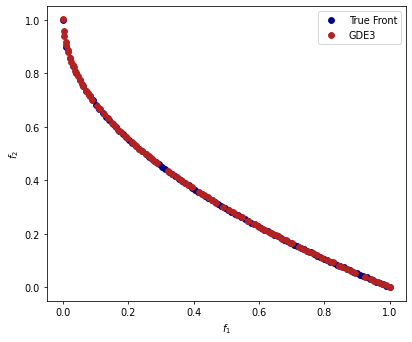

In [5]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=70)
ax.scatter(pf[:, 0], pf[:, 1], color="navy", label="True Front")
ax.scatter(res_gde3.F[:, 0], res_gde3.F[:, 1], color="firebrick", label="GDE3")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

Let us instantiate a GDE3 algorithm and pass as the improved survival operator ``RankAndCrowding(crowding_func="pcd")``, which recursively re-calculates crowding distances as removes individuals from the population. Alternatively, one could have directly imported the GDE3PCD algorithm.

```python
from pymoode.algorithms import GDE3PCD
```

In [6]:
gde3p = GDE3(
    pop_size=POPSIZE, variant="DE/rand/1/bin", CR=0.5, F=(0.0, 0.9), de_repair="bounce-back",
    survival=RankAndCrowding(crowding_func="pcd"),
)

res_gde3p = minimize(
    problem,
    gde3p,
    ('n_gen', NGEN),
    seed=SEED,
    save_history=False,
    verbose=False,
)

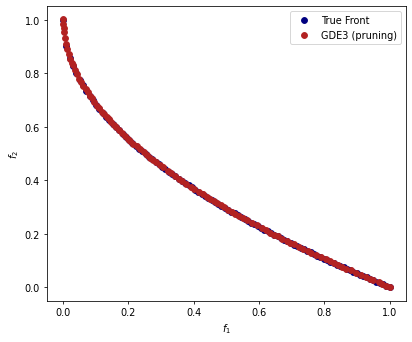

In [7]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=70)
ax.scatter(pf[:, 0], pf[:, 1], color="navy", label="True Front")
ax.scatter(res_gde3p.F[:, 0], res_gde3p.F[:, 1], color="firebrick", label="GDE3 (pruning)")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

## NSDE

Now let us adopt the ``NSDE`` algorithm. It is very similar to ``GDE3``, however, adopting a pure $(\mu + \lambda)$ survival strategy, which might lead to premature convergence in some problems of the ZDT test suite.

In [8]:
nsde = NSDE(
    pop_size=POPSIZE, variant="DE/rand/1/bin", CR=0.5, F=(0.0, 0.9), de_repair="bounce-back",
    survival=RankAndCrowding(crowding_func="pcd"),
)

res_nsde = minimize(
    problem,
    nsde,
    ('n_gen', NGEN),
    seed=SEED,
    save_history=False,
    verbose=False,
)

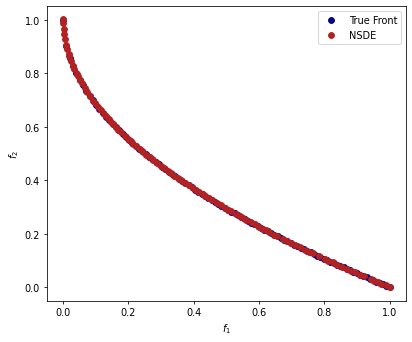

In [9]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=70)
ax.scatter(pf[:, 0], pf[:, 1], color="navy", label="True Front")
ax.scatter(res_nsde.F[:, 0], res_nsde.F[:, 1], color="firebrick", label="NSDE")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

But it worked very well in this example.

## Spacing

The spacing indicator is a quantitative metric of how good is the distribution of elements in the pareto front. It is described in more detail in the [complete tutorial](./Complete-tutorial.ipynb). One can also refer to <cite data-cite="multi_objective_book"></cite> for more details.

In [10]:
sp = SpacingIndicator(pf=problem.pareto_front(), zero_to_one=True)

The lesser the spacing, the more even the distribution of elements

In [11]:
print("Spacing of GDE3 with normal crowding distances: ", sp.do(res_gde3.F))
print("Spacing of GDE3 with pruning nds crowding distances: ", sp.do(res_gde3p.F))
print("Spacing of NSDE with pruning nds crowding distances: ", sp.do(res_nsde.F))

Spacing of GDE3 with normal crowding distances:  0.00671798902242222
Spacing of GDE3 with pruning nds crowding distances:  0.0026884699308083585
Spacing of NSDE with pruning nds crowding distances:  0.002587892035294526


In [12]:
igd = IGD(pf=problem.pareto_front(), zero_to_one=True)

In [13]:
print("IGD of GDE3 with normal crowding distances: ", igd.do(res_gde3.F))
print("IGD of GDE3 with pruning nds crowding distances: ", igd.do(res_gde3p.F))
print("IGD of NSDE with pruning nds crowding distances: ", igd.do(res_nsde.F))

IGD of GDE3 with normal crowding distances:  0.004552975587711302
IGD of GDE3 with pruning nds crowding distances:  0.0038818313760975985
IGD of NSDE with pruning nds crowding distances:  0.0039248610073845105
